# Data Acquisition


 
All of the data sets are time series of monthly activity. 

**Monthly mobile access** - The API separates mobile access types into two separate requests, data from mobile app and mobile web are summed up to make one count for all mobile pageviews. 
mobile access data is stored in a file called: dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
    
**Monthly desktop access** - Monthly desktop page traffic is based on one single request. 
Desktop access data in a file called: dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json
    
**Monthly cumulative** - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. 
Monthly cumulative data is stored in a file called: dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json



## Collect the articles to use

The csv file was imported into pandas dataframe for further use

In [109]:
import pandas as pd

In [110]:
articles=pd.read_csv('dinosaurs.csv')

In [111]:
#Cleaning the name of the dinosaurs to use later
articles['name'][0]='Coelosaurus antiquus'

In [112]:
#Extracting all the articles names from the dataframe into a list
articles_list=[x for x in articles.name]

In [113]:
articles.head()

,name,url
0,Coelosaurus antiquus,https://en.wikipedia.org/wiki/”Coelosaurus”_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus


The below 3 blocks of code template was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program
This below code snippets illustrates how to access page view data using the Wikimedia REST API. This example shows how to request monthly counts of page views for one specific article. The API documentation, pageviews/per-article, covers additional details that may be helpful when trying to use or understand this example.

Licence : This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - May 5, 2022


In [114]:

# These are standard python modules
import json, time, urllib.parse
import numpy as np

# The 'requests' and 'operator' modules are not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import operator

The example relies on some constants that help make the code a bit more readable.

In [115]:

#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<ksahoo@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

params=[ARTICLE_PAGEVIEWS_PARAMS_DESKTOP,ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB,ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP] # list of paramters for each access type

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [58]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace('"','').replace(' ','_'))
    request_template['article'] = article_title_encoded
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Collecting data and storing in json format for each article in the articles list for each access type


In [ ]:

for param in params:
    print(' checking for param {}'.format(param))
    data={'items':[]} #An empty dictionary to collect the article time series for all the articles in each access type 
    for article in articles_list:
        views = request_pageviews_per_article(article,request_template=param)
        data['items']=data['items']+views['items'] #recursively updating the empty dictionary with new values
    data_dict=data
    # Based on the access type it will store the final collected dictionary in corresponding json file
    if param['access']=='mobile-web':
        with open("mobile_web.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_mobile = json.dumps(data_dict, indent=4)
    if param['access']=='desktop':
        with open("desktop.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_desktop = json.dumps(data_dict, indent=4)
    else:
        with open("mobile_app.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_desktop = json.dumps(data_dict, indent=4)
       

Above output should show dictionaries with views per month

## Function to convert json to csv

The code base is sourced from the open source channel: GeeksforGeeks (https://www.geeksforgeeks.org/convert-json-to-csv-in-python/)

The jsons created above are converted to csv for processing of data easily in pandas dataframe

In [116]:
# function to convert json to csv

import json
import csv
def json_to_csv(input_file,output_file):
    
    # Opening JSON file and loading the data
    # into the variable data
    with open(input_file) as json_file:
        data = json.load(json_file)

    dino_data = data['items']
    print(dino_data[2])
    # now we will open a file for writing
    data_file = open(output_file, 'w')

    # create the csv writer object
    csv_writer = csv.writer(data_file)

    # Counter variable used for writing
    # headers to the CSV file
    count = 0

    for dino in dino_data:
        if count == 0:
            # Writing headers of CSV file
            header = dino.keys()
            csv_writer.writerow(header)
            count += 1
        # Writing data of CSV file
        csv_writer.writerow(dino.values())

    data_file.close()

In [24]:
#Creating csv files
json_to_csv('mobile_web.json','mobile_web.csv')
json_to_csv('mobile_app.json','mobile_app.csv')
json_to_csv('desktop.json','desktop.csv')

{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'mobile-web', 'agent': 'user', 'views': 9}
{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'mobile-app', 'agent': 'user', 'views': 2}
{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'desktop', 'agent': 'user', 'views': 80}


In [117]:
#Reading csv files into pandas dataframe
mobile_web=pd.read_csv('csv_data/mobile_web.csv')
mobile_app=pd.read_csv('csv_data/mobile_app.csv')
desktop=pd.read_csv('csv_data/desktop.csv')

In [118]:
mobile_web.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-web,user,16
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-web,user,12
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-web,user,9
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-web,user,21
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-web,user,13


In [119]:
mobile_app.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-app,user,4
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-app,user,2
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-app,user,2
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-app,user,0
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-app,user,0


In [120]:
desktop.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,desktop,user,79
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,desktop,user,62
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,desktop,user,80
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,desktop,user,66
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,desktop,user,72


## Combine mobile app and mobile web data into one

In [121]:
# mobile app and mobile web dataframes are appended on axis=0
mobile=pd.concat([mobile_web,mobile_app],axis=0)
mobile = mobile.sort_values(by = ['article', 'timestamp'], ascending = True)

In [122]:
mobile.head()

,project,article,granularity,timestamp,access,agent,views
87,en.wikipedia,Aachenosaurus,monthly,2015070100,mobile-web,user,429
87,en.wikipedia,Aachenosaurus,monthly,2015070100,mobile-app,user,14
88,en.wikipedia,Aachenosaurus,monthly,2015080100,mobile-web,user,397
88,en.wikipedia,Aachenosaurus,monthly,2015080100,mobile-app,user,15
89,en.wikipedia,Aachenosaurus,monthly,2015090100,mobile-web,user,275


In [123]:
# Overall views data for mobile access type is derived by the concatenated datasets of mobile web and mobile app 
mobile_grp=mobile.groupby(by=['project','article','granularity','timestamp','agent']).agg({'views':'sum'}).reset_index()
mobile_grp.columns=['project','article','granularity','timestamp','agent','views']
mobile_grp = mobile_grp.sort_values(by = ['article', 'timestamp'], ascending = True)

In [124]:
mobile_grp.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311


In [125]:
#The access type field is dropped
desktop_grp=desktop.loc[:,['project','article','granularity','timestamp','agent','views']]
desktop_grp = desktop_grp.sort_values(by = ['article', 'timestamp'], ascending = True)

In [126]:
desktop_grp.head()

,project,article,granularity,timestamp,agent,views
87,en.wikipedia,Aachenosaurus,monthly,2015070100,user,2671
88,en.wikipedia,Aachenosaurus,monthly,2015080100,user,13113
89,en.wikipedia,Aachenosaurus,monthly,2015090100,user,34235
90,en.wikipedia,Aachenosaurus,monthly,2015100100,user,5361
91,en.wikipedia,Aachenosaurus,monthly,2015110100,user,13502


In [127]:
#Desktop and mobile datasets are concatenated to get cumulative monthly views count for each article
all_access=pd.concat([mobile_grp,desktop_grp],axis=0)
columns = ['project', 'article', 'granularity', 'timestamp', 'agent']
all_access_grp_cum = all_access.groupby(columns).sum().groupby('article').cumsum().reset_index()
all_access_grp_cum = all_access_grp_cum.sort_values(by = ['article', 'timestamp'], ascending = True)
all_access_grp_cum.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,3114
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,16639
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,51157
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,57312
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,71125


## Store everything back in json after processing


In [128]:
#function to convert pandas dataframe to json
def df_to_json(df, jsonFilePath):
    result = df.to_json(orient="records")
    parsed = json.loads(result)
    with open(jsonFilePath, "w") as outfile:
            json.dump(parsed, outfile)

In [129]:
df_to_json(mobile_grp,'dino_monthly_mobile_201507-202209.json')
df_to_json(desktop_grp,'dino_monthly_desktop_201507-202209.json')
df_to_json(all_access_grp_cum,'dino_monthly_cumulative_201507-202209.json')


# Data Analysis

## Instructions
**Maximum Average and Minimum Average** - The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

**Top 10 Peak Page Views** - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

**Fewest Months of Data** - The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


## Maximum Average and Minimum Average

In [130]:
#Finding Average views per article for mobile access
mobile_grp_avg=mobile_grp.groupby(by=['article']).agg({'views':'mean'}).reset_index()
mobile_grp_avg.columns=['article','avg_views']
mobile_grp_avg=mobile_grp_avg.sort_values(by='avg_views')

In [131]:
mobile_grp_avg.tail()

,article,avg_views
1188,Stegosaurus,21131.471264
1285,Triceratops,21230.701149
1179,Spinosaurus,28958.413793
1327,Velociraptor,42094.091954
1301,Tyrannosaurus,59537.701149


In [132]:
#Getting the article with the highest and lowest views in mobile access
highest_article_mobile=mobile_grp_avg.iloc[-1,0]
lowest_article_mobile=mobile_grp_avg.iloc[0,0]
highest_article_mobile,lowest_article_mobile

('Tyrannosaurus', 'Honghesaurus')

In [133]:
#Finding Average views per article for desktop access
desktop_grp_avg=desktop_grp.groupby(by=['article']).agg({'views':'mean'}).reset_index()
desktop_grp_avg.columns=['article','avg_views']
desktop_grp_avg=desktop_grp_avg.sort_values(by='avg_views')

In [134]:
desktop_grp_avg.head()

,article,avg_views
561,Honghesaurus,16.965517
899,Ornithomerus,20.793103
888,Oligosaurus,22.517241
1043,Rachitrema,22.540230
975,Picrodon,24.275862


In [135]:
#Getting the articles with highest and lowest views for desktop
highest_article_desktop=desktop_grp_avg.iloc[-1,0]
lowest_article_desktop=desktop_grp_avg.iloc[0,0]
highest_article_desktop,lowest_article_desktop

('Tyrannosaurus', 'Honghesaurus')

In [136]:
#Plot charts
import matplotlib.pyplot as plt

### Changing the format of timestamp

In [137]:
desktop_grp['timestamp_1'] = desktop_grp['timestamp'].apply(lambda x: str(x)[0:8])
desktop_grp['timestamp_1'] = desktop_grp['timestamp_1'].astype(int)
mobile_grp['timestamp_1'] = mobile_grp['timestamp'].apply(lambda x: str(x)[0:8])
mobile_grp['timestamp_1'] = mobile_grp['timestamp_1'].astype(int)

In [138]:
desktop_grp['timestamp_1'] = pd.to_datetime(desktop_grp['timestamp_1'], format='%Y%m%d').dt.strftime('%m/%d/%Y')
mobile_grp['timestamp_1'] = pd.to_datetime(mobile_grp['timestamp_1'], format='%Y%m%d').dt.strftime('%m/%d/%Y')

In [139]:
mobile_grp.head()

,project,article,granularity,timestamp,agent,views,timestamp_1
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443,07/01/2015
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412,08/01/2015
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283,09/01/2015
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794,10/01/2015
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311,11/01/2015


C:\Users\khirod\AppData\Local\Temp\ipykernel_27768\476134830.py:14: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10)


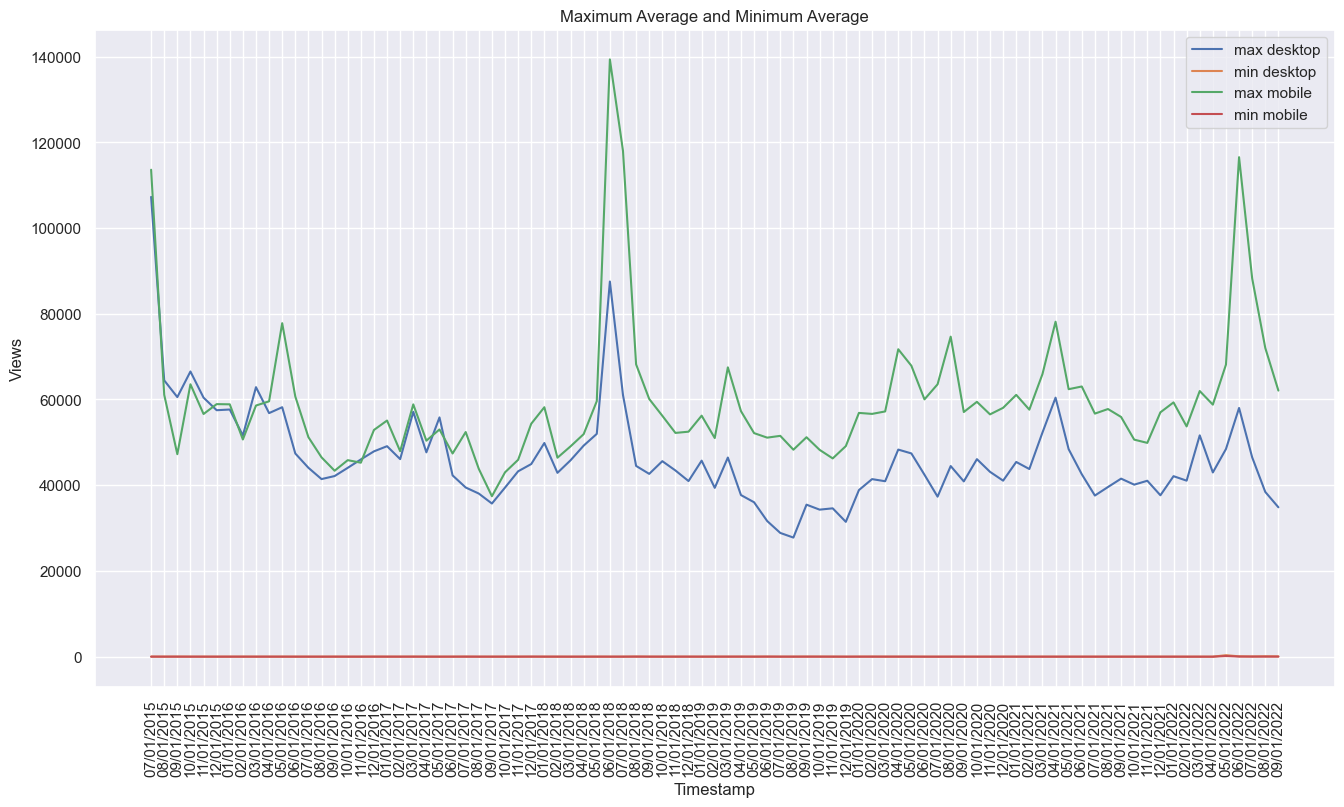

In [156]:
# plot 4 lines for articles with highest and lowest average views for desktop and mobile access
plt.figure(figsize = (16,9))
plt.plot(desktop_grp[desktop_grp['article']==highest_article_desktop].timestamp_1,\
         desktop_grp[desktop_grp['article']==highest_article_desktop].views, label = "max desktop")
plt.plot(desktop_grp[desktop_grp['article']==lowest_article_desktop].timestamp_1,\
         desktop_grp[desktop_grp['article']==lowest_article_desktop].views, label = "min desktop")
plt.plot(mobile_grp[mobile_grp['article']==highest_article_mobile].timestamp_1,\
         mobile_grp[mobile_grp['article']==highest_article_mobile].views, label = "max mobile")
plt.plot(mobile_grp[mobile_grp['article']==lowest_article_mobile].timestamp_1,\
         mobile_grp[mobile_grp['article']==lowest_article_mobile].views, label = "min mobile")
plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.title('Maximum Average and Minimum Average')
plt.locator_params(nbins=10)
plt.legend()
plt.xticks(rotation ='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom = 0.15)

#save plot in jpeg
plt.savefig('charts/Max_min_average.jpeg')
plt.show()

## Articles with top 10 Peak Page Views

In [141]:
#top 10 articles for desktop
m = desktop_grp.groupby('article')['views'].transform('max') == desktop_grp['views']
top_10_desktop=desktop_grp[m].sort_values(by='views',ascending=False).iloc[:10,:]
top_10_desktop

,project,article,granularity,timestamp,agent,views,timestamp_1
855,en.wikipedia,Achelousaurus,monthly,2021020100,user,205150,02/01/2021
105162,en.wikipedia,Velociraptor,monthly,2015070100,user,135741,07/01/2015
103272,en.wikipedia,Tyrannosaurus,monthly,2015070100,user,107257,07/01/2015
43310,en.wikipedia,Halszkaraptor,monthly,2017120100,user,103251,12/01/2017
40057,en.wikipedia,Giganotosaurus,monthly,2022060100,user,62340,06/01/2022
93439,en.wikipedia,Spinosaurus,monthly,2015070100,user,61029,07/01/2015
60236,en.wikipedia,Lythronax,monthly,2020060100,user,57701,06/01/2020
68436,en.wikipedia,Nigersaurus,monthly,2020020100,user,57192,02/01/2020
17187,en.wikipedia,Borealopelta,monthly,2019090100,user,53831,09/01/2019
29668,en.wikipedia,Dilophosaurus,monthly,2018060100,user,53278,06/01/2018


In [142]:
#top 10 articles for mobile
m = mobile_grp.groupby('article')['views'].transform('max') == mobile_grp['views']
top_10_mobile=mobile_grp[m].sort_values(by='views',ascending=False).iloc[:10,:]
top_10_mobile

,project,article,granularity,timestamp,agent,views,timestamp_1
68436,en.wikipedia,Nigersaurus,monthly,2020020100,user,235977,02/01/2020
28485,en.wikipedia,Deinocheirus,monthly,2021050100,user,234704,05/01/2021
40057,en.wikipedia,Giganotosaurus,monthly,2022060100,user,165007,06/01/2022
99962,en.wikipedia,Therizinosaurus,monthly,2022060100,user,155431,06/01/2022
105162,en.wikipedia,Velociraptor,monthly,2015070100,user,142284,07/01/2015
769,en.wikipedia,Achelousaurus,monthly,2021030100,user,140592,03/01/2021
103307,en.wikipedia,Tyrannosaurus,monthly,2018060100,user,139326,06/01/2018
17100,en.wikipedia,Borealopelta,monthly,2019090100,user,117282,09/01/2019
29716,en.wikipedia,Dilophosaurus,monthly,2022060100,user,78537,06/01/2022
9909,en.wikipedia,Argentinosaurus,monthly,2016120100,user,78437,12/01/2016


In [143]:
#creating a new column to identify the access type
mobile_grp['access']='mobile'
desktop_grp['access']='desktop'

In [144]:
import seaborn as sns

In [145]:
#subsetting mobile and desktop datasets by top 10 articles
df_top10_mobile=mobile_grp[mobile_grp['article'].isin(list(top_10_mobile.article))]
df_top10_desktop=desktop_grp[desktop_grp['article'].isin(list(top_10_desktop.article))]

In [146]:
#appending data subsets of both mobile and desktop access
top_10_all_access=pd.concat([df_top10_mobile,df_top10_desktop],axis=0)
top_10_all_access.head()

,project,article,granularity,timestamp,agent,views,timestamp_1,access
701,en.wikipedia,Achelousaurus,monthly,2015070100,user,464,07/01/2015,mobile
702,en.wikipedia,Achelousaurus,monthly,2015080100,user,321,08/01/2015,mobile
703,en.wikipedia,Achelousaurus,monthly,2015090100,user,301,09/01/2015,mobile
704,en.wikipedia,Achelousaurus,monthly,2015100100,user,322,10/01/2015,mobile
705,en.wikipedia,Achelousaurus,monthly,2015110100,user,325,11/01/2015,mobile


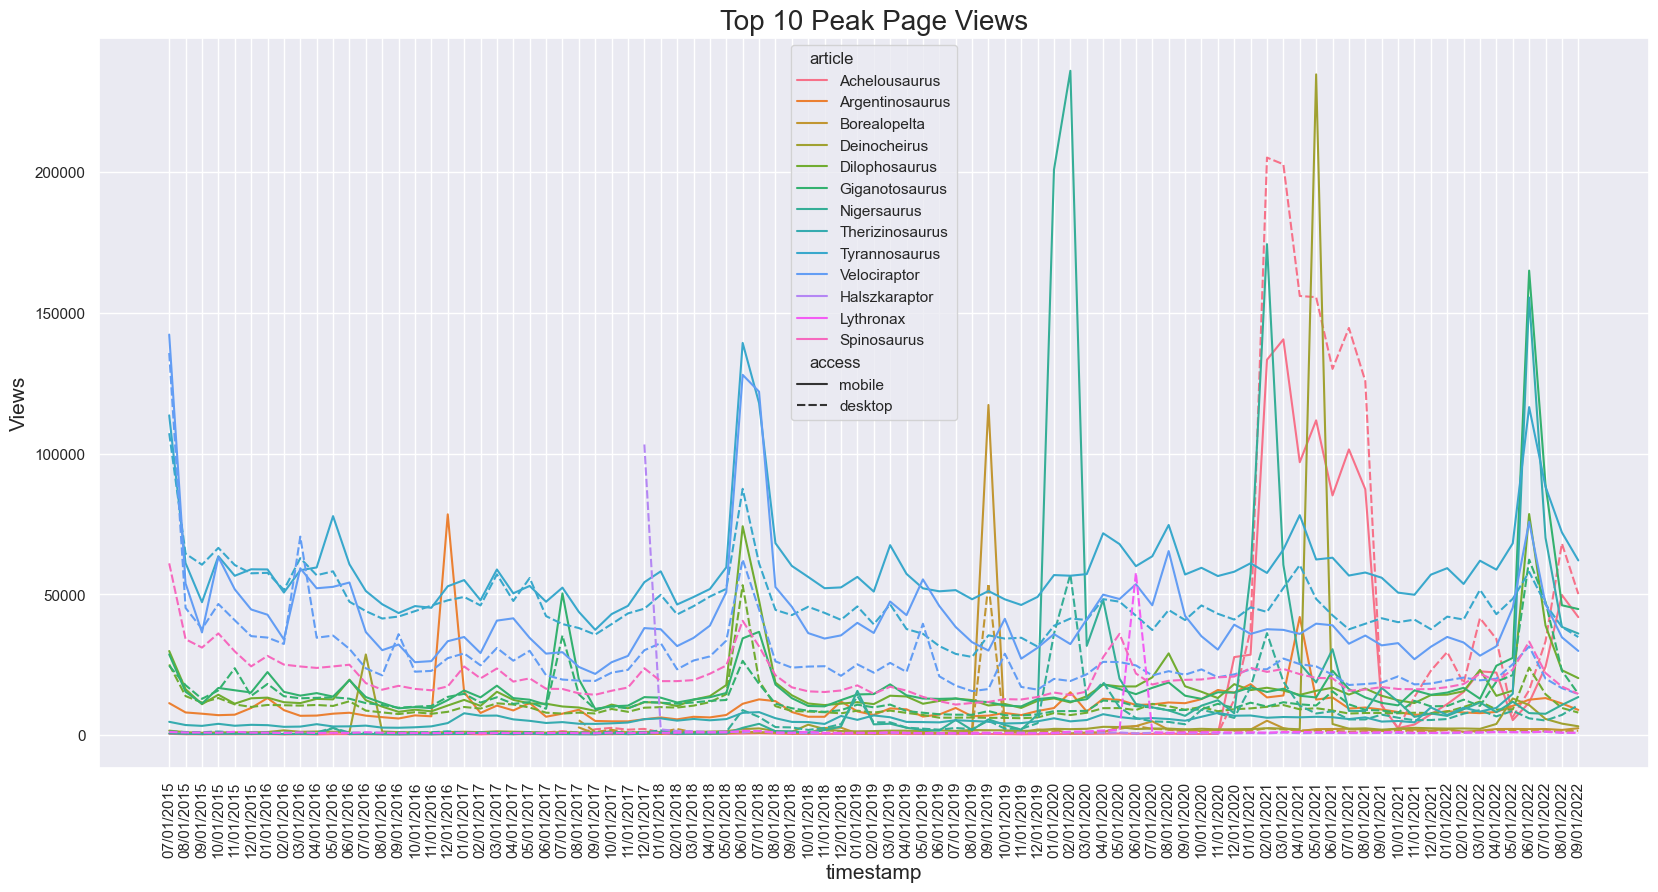

In [155]:
#Plot line charts using seaborn library
plt.figure(figsize = (20,10))
sns.set(style='darkgrid',)
sns.lineplot(x='timestamp_1', y='views', errorbar=None,hue='article',style='access', data=top_10_all_access,legend='brief')
plt.title("Top 10 Peak Page Views", fontsize = 20)
plt.xlabel("timestamp", fontsize = 15)
plt.ylabel("Views", fontsize = 15)
plt.xticks(rotation ='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom = 0.15)
#save plot in jpeg
plt.savefig('charts/top_10_articles.jpeg')
plt.show()

## Articles with fewest Months of Data

In [148]:
#Articles with fewest months of data for mobile
mobile_grp_count_months=mobile_grp.groupby(by=['article']).agg({'timestamp':'nunique'}).reset_index()
mobile_grp_count_months.columns=['article','months_count']
mobile_grp_count_months=mobile_grp_count_months.sort_values(by='months_count').iloc[:10]

In [149]:
mobile_grp_count_months

,article,months_count
414,Elemgasem,1
1295,Tuebingosaurus,1
617,Jakapil,2
791,Mbiresaurus,2
966,Perijasaurus,2
208,Bisticeratops,2
615,Iyuku,3
938,Paralitherizinosaurus,5
189,Bashanosaurus,7
403,Dzharaonyx,7


In [150]:
#Articles with fewest months of data for desktop
desktop_grp_count_months=desktop_grp.groupby(by=['article']).agg({'timestamp':'nunique'}).reset_index()
desktop_grp_count_months.columns=['article','months_count']
desktop_grp_count_months=desktop_grp_count_months.sort_values(by='months_count').iloc[:10]

In [151]:
desktop_grp_count_months

,article,months_count
414,Elemgasem,1
1295,Tuebingosaurus,1
617,Jakapil,2
791,Mbiresaurus,2
966,Perijasaurus,2
208,Bisticeratops,2
615,Iyuku,3
938,Paralitherizinosaurus,5
189,Bashanosaurus,7
403,Dzharaonyx,7


In [152]:
#subsetting mobile and desktop datasets by articles with fewest months of data
df_min_mths_desktop=desktop_grp[desktop_grp['article'].isin(list(desktop_grp_count_months.article))]
df_min_mths_mobile=mobile_grp[mobile_grp['article'].isin(list(mobile_grp_count_months.article))]

In [153]:
#appending data subsets of both mobile and desktop access
few_months_all_access=pd.concat([df_min_mths_desktop,df_min_mths_mobile],axis=0)
few_months_all_access.head()

,project,article,granularity,timestamp,agent,views,timestamp_1,access
15207,en.wikipedia,Bashanosaurus,monthly,2022030100,user,2351,03/01/2022,desktop
15208,en.wikipedia,Bashanosaurus,monthly,2022040100,user,438,04/01/2022,desktop
15209,en.wikipedia,Bashanosaurus,monthly,2022050100,user,385,05/01/2022,desktop
15210,en.wikipedia,Bashanosaurus,monthly,2022060100,user,379,06/01/2022,desktop
15211,en.wikipedia,Bashanosaurus,monthly,2022070100,user,307,07/01/2022,desktop


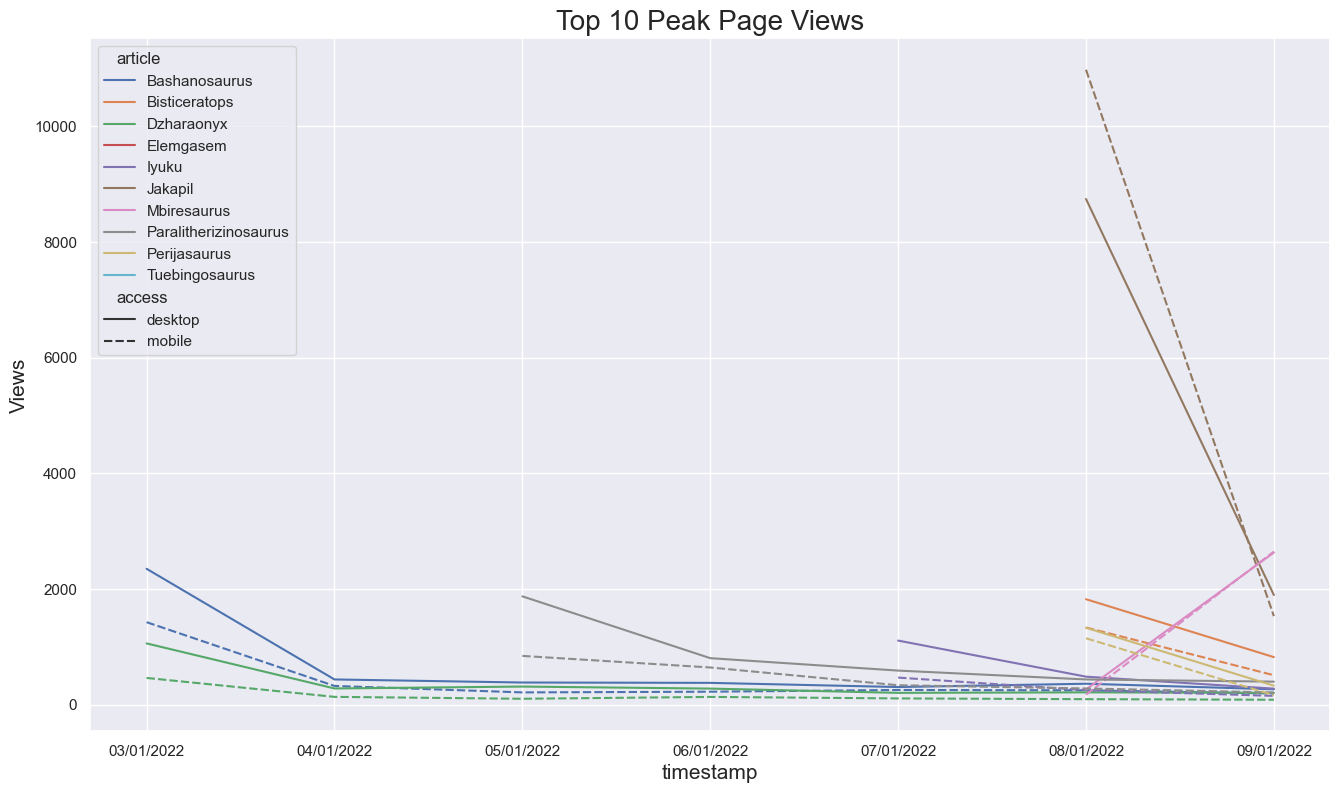

In [157]:
#Plot line charts using seaborn library
plt.figure(figsize = (16,9))
sns.set(style='darkgrid',)
sns.lineplot(x='timestamp_1', y='views', errorbar=None,hue='article',style='access', data=few_months_all_access,legend='brief')
plt.title("Top 10 Peak Page Views", fontsize = 20)
plt.xlabel("timestamp", fontsize = 15)
plt.ylabel("Views", fontsize = 15)
#save plot in jpeg
plt.savefig('charts/fewest_months.jpeg')
plt.show()